In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import h5py

from utils import load_dict

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

## 1. Photons transfer functions

In [2]:
run_name = '230629'

#data_dir = os.environ['DM21CM_DATA_DIR'] + f'/tf/{run_name}'
data_dir = os.environ['DM21CM_DATA_DIR'] + f'/tf/{run_name}'
save_dir = os.environ['DM21CM_DATA_DIR'] + f'/tf/{run_name}'
os.listdir(data_dir+'/phot')

['lep_tf_rxneo.npy',
 'phot_dep.h5',
 'lowerbound_rxneo.npy',
 'phot_depgv.npy',
 'hed_tf_rxneo.npy',
 'cmbloss_rxneo.npy',
 'phot_tfgv.npy',
 'phot_phot.h5',
 'phot_scat.h5',
 'hep_tf_rxneo.npy',
 'phot_prop.h5',
 '.ipynb_checkpoints',
 'ionhist_output',
 'phot_prop_diag.h5',
 'lee_tf_rxneo.npy']

In [3]:
abscs = load_dict(f"../data/abscissas/abscs_{run_name}.h5")

## 1.1 Photon number transfer function
- `tfgv` is already in $N\rightarrow N$.
- `tfgv` is ~ (rs x nBs Ein out). Transpose to make it ~ (rs Ein nBs x out).

### 1.1.1 phot_phot

In [4]:
data = np.load(data_dir + '/phot/phot_tfgv.npy')
data_permuted = np.einsum('rxneo -> renxo', data)
print(data.shape, '->', data_permuted.shape)

(10, 10, 10, 500, 500) -> (10, 500, 10, 10, 500)


In [5]:
with h5py.File(f"{save_dir}/phot/phot_phot.h5", 'w') as hf:
    hf.create_dataset('axes', data=np.array(['rs', 'Ein', 'nBs', 'x', 'out'], dtype=h5py.string_dtype()))
    hf_abscs = hf.create_group('abscs')
    hf_abscs.create_dataset('rs',  data=abscs['rs'][:])
    hf_abscs.create_dataset('Ein', data=abscs['photE'][:])
    hf_abscs.create_dataset('nBs', data=abscs['nBs'][:])
    hf_abscs.create_dataset('x',   data=abscs['x'][:])
    hf_abscs.create_dataset('out', data=abscs['photE'][:])
    hf.create_dataset('data', data=data_permuted)

### 1.1.2 phot_prop

In [6]:
data = np.load(data_dir + '/phot/phot_tfgv.npy')
data_prop = np.zeros_like(data)
for i in range(10):
    for j in range(10):
        for k in range(10):
            np.fill_diagonal(data_prop[i,j,k], np.diagonal(data[i,j,k]))
data_prop_permuted = np.einsum('rxneo -> renxo', data_prop)
print(data.shape, '->', data_prop_permuted.shape)

(10, 10, 10, 500, 500) -> (10, 500, 10, 10, 500)


In [7]:
with h5py.File(f"{save_dir}/phot/phot_prop.h5", 'w') as hf:
    hf.create_dataset('axes', data=np.array(['rs', 'Ein', 'nBs', 'x', 'out'], dtype=h5py.string_dtype()))
    hf_abscs = hf.create_group('abscs')
    hf_abscs.create_dataset('rs',  data=abscs['rs'][:])
    hf_abscs.create_dataset('Ein', data=abscs['photE'][:])
    hf_abscs.create_dataset('nBs', data=abscs['nBs'][:])
    hf_abscs.create_dataset('x',   data=abscs['x'][:])
    hf_abscs.create_dataset('out', data=abscs['photE'][:])
    hf.create_dataset('data', data=data_prop_permuted)

### 1.1.3 phot_prop_diag

In [8]:
data_prop_diag = np.zeros((10, 10, 10, 500))
for i in range(10):
    for j in range(10):
        for k in range(10):
            data_prop_diag[i,j,k] = np.diagonal(data[i,j,k])
data_prop_diag_permuted = np.einsum('rxno -> rnxo', data_prop_diag) # o for both input and output
print(data_prop_diag_permuted.shape)

(10, 10, 10, 500)


In [9]:
with h5py.File(f"{save_dir}/phot/phot_prop_diag.h5", 'w') as hf:
    hf.create_dataset('axes', data=np.array(['rs', 'nBs', 'x', 'out'], dtype=h5py.string_dtype()))
    hf_abscs = hf.create_group('abscs')
    hf_abscs.create_dataset('rs',  data=abscs['rs'][:])
    hf_abscs.create_dataset('nBs', data=abscs['nBs'][:])
    hf_abscs.create_dataset('x',   data=abscs['x'][:])
    hf_abscs.create_dataset('out', data=abscs['photE'][:])
    hf.create_dataset('data', data=data_prop_diag_permuted)

### 1.4 phot_scat

In [10]:
data_scat = data - data_prop
data_scat_permuted = np.einsum('rxneo -> renxo', data_scat)
print(data.shape, '->', data_scat_permuted.shape)

(10, 10, 10, 500, 500) -> (10, 500, 10, 10, 500)


In [11]:
with h5py.File(f"{save_dir}/phot/phot_scat.h5", 'w') as hf:
    hf.create_dataset('axes', data=np.array(['rs', 'Ein', 'nBs', 'x', 'out'], dtype=h5py.string_dtype()))
    hf_abscs = hf.create_group('abscs')
    hf_abscs.create_dataset('rs',  data=abscs['rs'][:])
    hf_abscs.create_dataset('Ein', data=abscs['photE'][:])
    hf_abscs.create_dataset('nBs', data=abscs['nBs'][:])
    hf_abscs.create_dataset('x',   data=abscs['x'][:])
    hf_abscs.create_dataset('out', data=abscs['photE'][:])
    hf.create_dataset('data', data=data_scat_permuted)

In [12]:
del data_prop, data_scat, data

## 1.2 Energy deposition transfer function
- `tfgv` is f values ($E\rightarrow E$ or $N\rightarrow N$ equivalently). To make it a $N\rightarrow E$ transfer function, need to first multiply by the energy abscissa.
- `tfgv` is ~ (nBs x rs Ein out). Transpose to make it ~ (rs Ein nBs x out).

### 1.2.1 phot_dep

In [13]:
data = np.load(data_dir + '/phot/phot_depgv.npy')
data_permuted = np.einsum('rxneo -> renxo', data)
print(data.shape, '->', data_permuted.shape)

(10, 10, 10, 500, 6) -> (10, 500, 10, 10, 6)


In [14]:
# multiply in energy
data_NEtf = np.einsum('renxo,e->renxo', data_permuted, abscs['photE'][:])

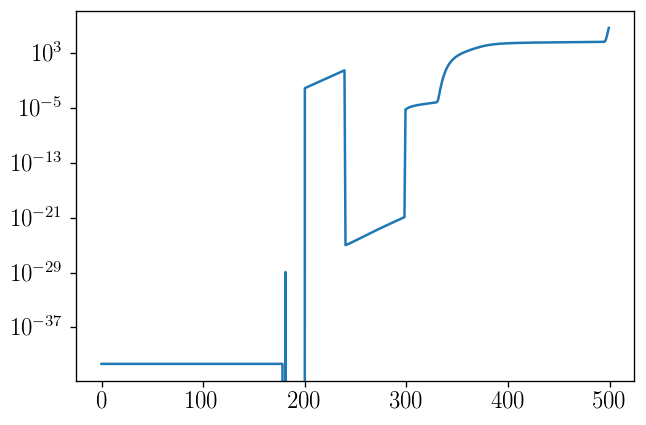

In [15]:
plt.plot(data_NEtf[3,:,4,5,-1])
plt.yscale('log')

In [16]:
with h5py.File(f"{save_dir}/phot/phot_dep.h5", 'w') as hf:
    hf.create_dataset('axes', data=np.array(['rs', 'Ein', 'nBs', 'x', 'out'], dtype=h5py.string_dtype()))
    hf_abscs = hf.create_group('abscs')
    hf_abscs.create_dataset('rs',  data=abscs['rs'][:])
    hf_abscs.create_dataset('Ein', data=abscs['photE'][:])
    hf_abscs.create_dataset('nBs', data=abscs['nBs'][:])
    hf_abscs.create_dataset('x',   data=abscs['x'][:])
    hf_abscs.create_dataset('out', data=abscs['dep_c'][:])
    hf.create_dataset('data', data=data_NEtf)

### 1.2.2 phot_dep adjusting xray band energy

In [17]:
with h5py.File(f"{save_dir}/phot/phot_scat.h5", 'r') as hf:
    tf = hf['data'][:]

In [18]:
xray_eng_range = (1e2, 1e4)
i_xray_low = np.searchsorted(abscs['photE'], xray_eng_range[0])
i_xray_high = np.searchsorted(abscs['photE'], xray_eng_range[1])
print(i_xray_low, i_xray_high)

179 239


In [19]:
eng_tf = np.dot(tf[..., i_xray_low:i_xray_high], abscs['photE'][i_xray_low:i_xray_high])
print(eng_tf.shape)

(10, 500, 10, 10)


In [20]:
data_NEtf_withx = np.zeros((10, 500, 10, 10, 6))
data_NEtf_withx[...,:5] = data_NEtf[...,:5]
data_NEtf_withx[..., 5] = eng_tf

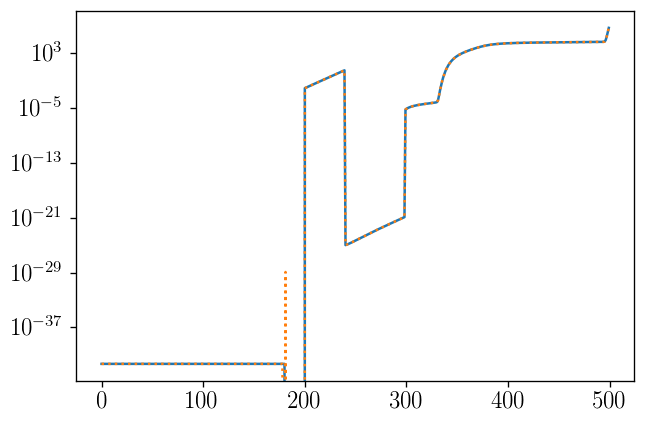

In [22]:
plt.plot(data_NEtf_withx[3,:,4,5,5])
plt.plot(data_NEtf[3,:,4,5,5], ls=':')
plt.yscale('log')

In [23]:
with h5py.File(f"{save_dir}/phot/phot_dep.h5", 'w') as hf:
    hf.create_dataset('axes', data=np.array(['rs', 'Ein', 'nBs', 'x', 'out'], dtype=h5py.string_dtype()))
    hf_abscs = hf.create_group('abscs')
    hf_abscs.create_dataset('rs',  data=abscs['rs'][:])
    hf_abscs.create_dataset('Ein', data=abscs['photE'][:])
    hf_abscs.create_dataset('nBs', data=abscs['nBs'][:])
    hf_abscs.create_dataset('x',   data=abscs['x'][:])
    hf_abscs.create_dataset('out', data=abscs['dep_c'][:])
    hf.create_dataset('data', data=data_NEtf_withx)

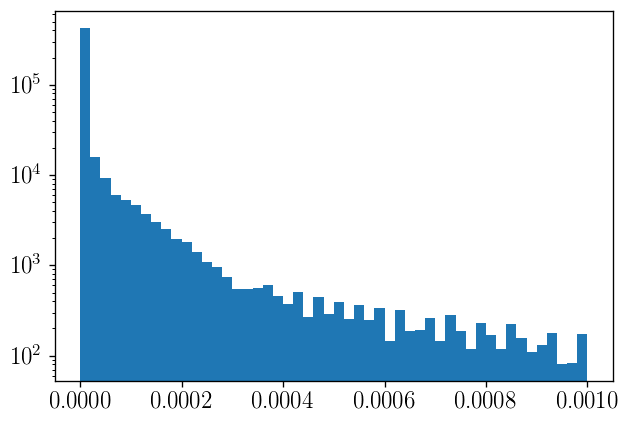

In [24]:
# check f values
f_tf = eng_tf / abscs['photE'][:][None, :, None, None]
plt.hist(f_tf.flatten(), bins=50, range=(0,0.001))
plt.yscale('log');

# Electrons transfer functions

## 1. Energy deposition transfer function
- `tfgv` is f values ($E\rightarrow E$). To make it a $N\rightarrow E$ transfer function, need to first multiply by the energy abscissa.
- `tfgv` is ~ (rs Ein x out).

In [ ]:
data_dir = os.environ['DM21CM_DATA_DIR'] + '/tf/230408'

In [ ]:
os.listdir(data_dir+'/elec')

In [ ]:
abscs_in_tf = {
    'rs' : abscs['rs'],
    'Ein' : abscs['elecEk'],
    'x' : abscs['x'],
    'out' : abscs['dep_c']
}

In [ ]:
data = np.load(data_dir+'/elec/depgv_rexo.npy')
print(data.shape)

In [ ]:
# multiply in energy
eng = abscs['Ein']
data_NEtf = np.einsum('rexo,e->rexo', data, eng)
print(data_NEtf.shape)

In [ ]:
pickle.dump((abscs, data_NEtf), open(data_dir + '/elec_dep_dlnz4.879E-2_rexo_ad.p', 'wb'))

## 2. Electron number transfer function
- `tfgv` is already in $N\rightarrow N$.
- `tfgv` is ~ (rs Ein x out).

In [ ]:
abscs = {
    'rs' : abscs_nBs['rs'],
    'Ein' : abscs_nBs['elecEk'],
    'x' : abscs_nBs['x'],
    'out' : abscs_nBs['photE']
}

In [ ]:
data = np.load(data_dir + '/elec_phot_tfgv_rexo.npy')
print(data.shape)

In [ ]:
pickle.dump((abscs, data), open(data_dir + '/elec_tf_dlnz4.879E-2_rexo_ad.p', 'wb'))

## A. Compound to fixed power (48)

In [17]:
from jax import jit
import jax.numpy as jnp

from tqdm import tqdm

In [18]:
@jit
def compound_48(tf, dep):
    
    dot = jnp.dot
    
    s2 = jnp.identity(tf.shape[0]) + tf
    p2 = dot(tf, tf)
    s4 = s2 + dot(p2, s2)
    p4 = dot(p2, p2)
    s8 = s4 + dot(p4, s4)
    p8 = dot(p4, p4)
    s16 = s8 + dot(p8, s8)
    p16 = dot(p8, p8)
    s32 = s16 + dot(p16, s16)
    p32 = dot(p16, p16)
    
    p48 = dot(p32, p16)
    s48 = s32 + dot(p32, s16)
    #p50 = dot(p48, p2)
    #s50 = s32 + dot(p32, s16) + dot(p48, s2)
    
    return p48, dot(s48, dep)

In [19]:
tf_abscs, tf_full = pickle.load(open(data_dir + '/phot_tf_nxreo_ad.p', 'rb'))
dep_abscs, dep_full = pickle.load(open(data_dir + '/phot_dep_nxreo_ad.p', 'rb'))

In [20]:
ctf_full = np.zeros_like(tf_full)
cdep_full = np.zeros_like(dep_full)

n_i, n_j, n_k, _, _ = tf_full.shape
pbar = tqdm(total=n_i*n_j*n_k)

for i in range(n_i):
    for j in range(n_j):
        for k in range(n_k):
            tf = tf_full[i,j,k]
            dep = dep_full[i,j,k]
            ctf, cdep = compound_48(tf, dep)
            ctf_full[i,j,k] = np.array(ctf)
            cdep_full[i,j,k] = np.array(cdep)
            pbar.update()

100%|█████████▉| 1999/2000 [00:27<00:00, 61.75it/s]

In [21]:
pickle.dump((tf_abscs, ctf_full), open(data_dir + '/phot_ctf_dlnz48m_nxreo_ad.p', 'wb'))
pickle.dump((dep_abscs, cdep_full), open(data_dir + '/phot_cdep_dlnz48m_nxreo_ad.p', 'wb'))

100%|██████████| 2000/2000 [00:43<00:00, 61.75it/s]

### 3.1 permute

In [22]:
# tf
print(ctf_full.shape, end=' -> ')
ctf_full_permuted = np.transpose(ctf_full, axes=[2, 3, 0, 1, 4])
print(ctf_full_permuted.shape)
# dep
print(cdep_full.shape, end=' -> ')
cdep_full_permuted = np.transpose(cdep_full, axes=[2, 3, 0, 1, 4])
print(cdep_full_permuted.shape)

(10, 10, 20, 500, 500) -> (20, 500, 10, 10, 500)
(10, 10, 20, 500, 5) -> (20, 500, 10, 10, 5)


In [23]:
pickle.dump((tf_abscs, ctf_full_permuted), open(data_dir + '/phot_ctf_dlnz48m_renxo_ad.p', 'wb'))
pickle.dump((dep_abscs, cdep_full_permuted), open(data_dir + '/phot_cdep_dlnz48m_renxo_ad.p', 'wb'))

In [24]:
! du -smh /data/submit/yitians/DM21cm/transferfunctions/nBs_test/*

3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/archive
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_cdep_dlnz48m_nxreo_ad.p
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_cdep_dlnz48m_renxo_ad.p
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_ctf_dlnz48m_nxreo_ad.p
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_ctf_dlnz48m_renxo_ad.p
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_depgv.npy
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_dep_nxreo_ad.p
39M	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_dep_renxo_ad.p
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_tfgv.npy
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_tf_nxreo_ad.p
3.8G	/data/submit/yitians/DM21cm/transferfunctions/nBs_test/phot_tf_renxo_ad.p
